In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from matplotlib.patches import Rectangle

### Благодаря бутстрап методу мы можем осуществлять проверку гипотез на метриках, для которых не существует критериев, а также создавать доверительные интервалы для этих метрик.

#### 1. Традиционная проверка гипотез с подсчетом p-value.

Шаги алгоритма:

1. Вычисляем модуль разности метрик на исходных выборках.
2. Объединяем исходные выборки в одну.
3. Генерируем бутстрап выборку из объединенной выборки, сохраняя ее размер.
4. Случайным образом разделяем выборку из шага 3 на две части.
5. Вычисляем разность метрик и сохраняем ее.
6. Повторяем шаги 3-5 от 1000 до 10000 раз.
7. Подсчитываем количество статистик, которые приняли значение меньше или больше метрики из шага 1.
8. Нормируем это значение на количество повторений из шага 6.

In [11]:
def bootstrap(a_sample, b_sample, func=np.mean):
    """
    Выполняет процедуру бутстрапа для оценки разности между двумя выборками.
    """
    ab_concat = np.concatenate([a_sample, b_sample]) # объединяем выборки a и b вместе
    ab_size = ab_concat.size # считаем размер объединенной выборки
    a_size = a_sample.size # считаем размер выборки a
    b_size = b_sample.size # считаем размер выборки b

    bootstrap = np.random.choice(ab_concat, size=ab_size, replace=True) # генерируем бутстрап выборку
    a_bootstrap = bootstrap[:a_size] # делим выборку на две части
    b_bootstrap = bootstrap[b_size:]

    stat_diff = func(a_bootstrap) - func(b_bootstrap) # считаем разность статистик

    return stat_diff

In [9]:
# генерируем две выборки из произвольного распределения
a = np.random.normal(0, 10, size=1000)
b = np.random.normal(1, 10, size=1000)

func = lambda x: np.quantile(x, 0.9) # функция, для подсчета статистики

# для правльного подсчета p-value, считаем модуль разности статистик
stat_diff = abs(func(b) - func(a))

stat_distr = []
for _ in range(1000):
    stat = bootstrap(a, b, func=func)
    stat_distr.append(stat)

stat_distr = np.array(stat_distr)

# для проверки двухсторонней гипотезы проверяем, сколько раз
# бутстрап статистика приняла значение меньше и больше статистики,
# посчитанной по оригинальным выборкам
p_val = (stat_distr >= stat_diff).sum() + (stat_distr <= -stat_diff).sum()

# и нормируем значение
p_val_norm = p_val / len(stat_distr)

alpha = 0.05
conclusion = 'не отвергаем' if p_val_norm > alpha else 'отвергаем'

print(f'p-value = {p_val_norm:0.3f}, H0: {conclusion}')

p-value = 0.291, H0: не отвергаем


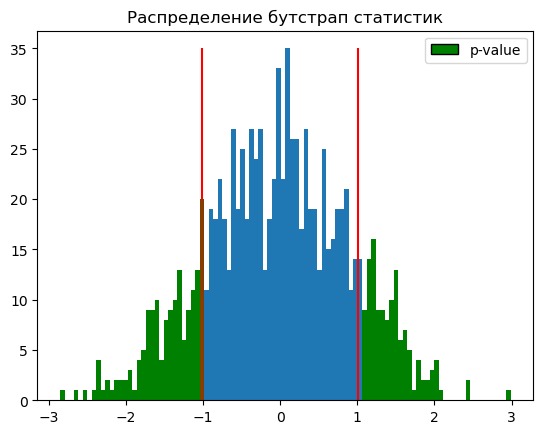

In [10]:
# визуализируем распределение статистик

n, bins, patches = plt.hist(stat_distr, bins=100)

ymax = n.max()
plt.vlines([-stat_diff, stat_diff],
           ymin=0, 
           ymax=ymax, 
           color='r')

p_val_color = 'g'
for index, p in enumerate(patches):
    if p.get_x() <= -stat_diff or p.get_x() >= stat_diff:
        p.set_facecolor(p_val_color)

rect_label = [Rectangle((0,0), 1, 1, color=p_val_color, ec='k')]
plt.legend(rect_label, ['p-value'])

plt.title('Распределение бутстрап статистик')

plt.show();

#### 2. Вычисление доверительного интервала для разности метрик.

Шаги алгоритма:

1. Создаем пары бутстрап подвыборок, каждая из которых имеет тот же размер, что и исходные данные, для контрольной и экспериментальной групп.
2. Вычисляем метрики для каждой из групп.
3. Рассчитываем разницу между метриками и сохраняем эту разность.
4. Повторяем шаги 1-3 от 1000 до 10000 раз.
5. Строим доверительный интервал с уровнем значимости альфа.
6. Если ноль не попадает в доверительный интервал, то различия статистически значимы на уровне значимости альфа, в противном случае различия не являются статистически значимыми.

Доверительный интервал будем использовать нормальный и перцептильный.

1. Нормальный доверительный интервал имеют формулу $P( \bar{pe} \pm z \cdot \frac{\sigma}{\sqrt{n}}) \geq 1 - \alpha$, где:
    * $\bar{pe}$ - точечная оценка по истинной выборке
    * $z$ - квантиль нормального распределения
    * $\frac{\sigma}{\sqrt{n}}$ - стандартная ошибка среднего, для метрик, посчитанных на основе бутстрап выборок нужно посчитать только среднеквадратическое отклонение
    * $\alpha$ - вероятность ошибки первого рода

2. Чтобы посчитать перцентильный доверительный интервал, нужно отбросить крайние значения $\alpha/2$ и $1-\alpha/2$.

In [13]:
def normal_ci(pe, bootstrap_sample, alpha=0.05):
    """
    Нормальный доверительный интервал
    """
    z_quantile = stats.norm().ppf(1 - alpha / 2)
    se = np.std(bootstrap_sample)
    left, right = pe - z_quantile * se, pe + z_quantile * se
    return left, right


def percentile_ci(bootstrap_sample, alpha=0.05):
    """
    Перцентильный доверительный интервал
    """
    left, right = np.quantile(bootstrap_sample, [alpha/2, 1-alpha/2])
    return left, right

In [14]:
# В качестве примера, мы создадим две выборки размера 1000 из нормального 
# распределения и вычислим разницу между 0.99-м квантилем.

n = 1000
a_sample = np.random.normal(loc=11, scale=4, size=n)
b_sample = np.random.normal(loc=11, scale=2, size=n)

# точечная оценка для разницы квантилей
pe = np.quantile(b_sample, 0.99) - np.quantile(a_sample, 0.99) 

# количество генерируемых подвыборок, оптимально 1000-10000
B = 5000 

# генерируем выборки с возвращением
bootstrap_a_sample = np.random.choice(a_sample, size=(B, n), replace=True)
bootstrap_b_sample = np.random.choice(b_sample, size=(B, n), replace=True)

# считаем 0.99 квантиль для каждой подвыборки
bootstrap_a_metrics = np.quantile(bootstrap_a_sample, 0.99, axis=1)
bootstrap_b_metrics = np.quantile(bootstrap_b_sample, 0.99, axis=1)

# считаем разницу квантилей
bootstrap_pe = bootstrap_b_metrics - bootstrap_a_metrics

In [17]:
# остается посчитать доверительный интервал для точечной оценки

n_left, n_right = normal_ci(pe, bootstrap_pe)
p_left, p_right = percentile_ci(bootstrap_pe)

normal_ci_result = 'не отвергаем' if n_left <= 0 <= n_right else 'отвергаем'
percentile_ci_result = 'не отвергаем' if p_left <= 0 <= p_right else 'отвергаем'

print(f'На основе нормального доверительного интервала гипотезу {normal_ci_result}.\n'
        f'На основе перцентильного доверительного интервала гипотезу {percentile_ci_result}.\n\n'

        f'Согласно нормального ДИ, истинное значение лежит в интервале ({n_left:0.2f}, {n_right:0.2f})\n'
        f'и ({p_left:0.2f}, {p_right:0.2f}) согласно перцентильго ДИ.'
)

На основе нормального доверительного интервала гипотезу отвергаем.
На основе перцентильного доверительного интервала гипотезу отвергаем.

Согласно нормального ДИ, истинное значение лежит в интервале (-5.84, -4.11)
и (-5.94, -4.09) согласно перцентильго ДИ.


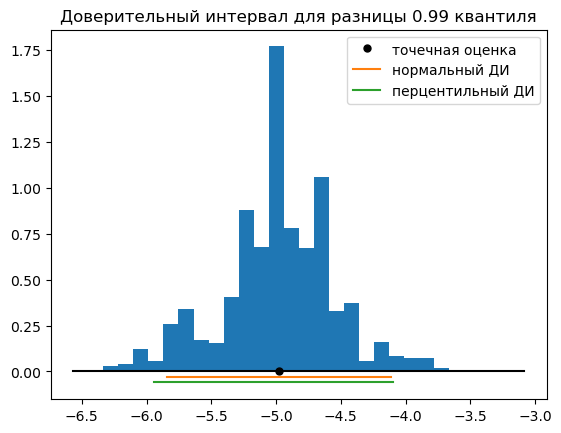

In [19]:
# визуализируем полученные результаты

plt.hist(bootstrap_pe, bins=30, density=True)

plt.plot(pe, 0, 'o', c='black', markersize=5, label='точечная оценка')

p = 0.03
plt.plot([n_left, n_right], [-p, -p], label='нормальный ДИ')
plt.plot([p_left, p_right], [-p*2, -p*2], label='перцентильный ДИ')
plt.plot([bootstrap_pe.min(), bootstrap_pe.max()], [0, 0], c='black')

plt.title('Доверительный интервал для разницы 0.99 квантиля')
plt.legend()

plt.show();

#### 3. Размер выборки.

Согласно этой [статье](https://habr.com/ru/companies/lamoda/articles/707816/), для удержания $\alpha$ и мощности $1 - \beta$ на заданном уровне, можно применить формулу для расчета необходимого размера выборки при использовании t-теста.

Формула для расчета необходимого размера выборки для t-теста при одинаковой дисперсии:
$n = 2 \left(z_{\frac{\alpha}{2}} + z_{\beta}\right)^2 \left(\frac{\sigma}{\mu_1 - \mu_2}\right)^2$

Формула для расчета необходимого размера выборки для t-теста при разной дисперсии:
$n = \left(z_{\frac{\alpha}{2}} + z_{\beta}\right)^2 \frac{{\sigma_1^2 + \sigma_2^2}}{{(\mu_1 - \mu_2)^2}}$
